In [1]:
import pandas as pd
import numpy as np
import os
import glob
from collections import defaultdict

# --- Directory Configuration ---
base_path = r"C:\Users\Danish Laptop\Downloads\Current Signature Dataset of Three-Phase Induction Motor under Varying Load Conditions"
folders_path = [
    os.path.join(base_path, "3-Phase-current-0.7mm-bearing-fault"),
    os.path.join(base_path, "3-Phase-current-0.9mm-bearing-fault"),
    os.path.join(base_path, "3-Phase-current-1.1mm-bearing-fault"),
    os.path.join(base_path, "3-Phase-current-1.3mm-bearing-fault"),
    os.path.join(base_path, "3-Phase-current-1.5mm-bearing-fault"),
    os.path.join(base_path, "3-Phase-current-1.7mm-bearing-fault"),
    os.path.join(base_path, "3-Phase-current-12-4mm-broken-rotor-bar-fault"),
    os.path.join(base_path, "3-Phase-current-healthy-motor")
]

# Map folder names to detailed labels
fault_mapping = {
    "3-Phase-current-healthy-motor": "Healthy",
    "3-Phase-current-0.7mm-bearing-fault": "Unhealthy - 0.7mm Bearing Fault",
    "3-Phase-current-0.9mm-bearing-fault": "Unhealthy - 0.9mm Bearing Fault",
    "3-Phase-current-1.1mm-bearing-fault": "Unhealthy - 1.1mm Bearing Fault",
    "3-Phase-current-1.3mm-bearing-fault": "Unhealthy - 1.3mm Bearing Fault",
    "3-Phase-current-1.5mm-bearing-fault": "Unhealthy - 1.5mm Bearing Fault",
    "3-Phase-current-1.7mm-bearing-fault": "Unhealthy - 1.7mm Bearing Fault",
    "3-Phase-current-12-4mm-broken-rotor-bar-fault": "Unhealthy - Broken Rotor Bar Fault"
}

# --- Configuration Parameters ---
num_cols = 1000
current_cols = [' Current-A', ' Current-B', ' Current-C']

# --- Global lists to track issues ---
missing_files = []
insufficient_data_files = []
missing_column_files = []

# --- Function to process a single file ---
def process_file_for_labeling(filename, label, num_cols=1000, current_cols=[' Current-A',' Current-B',' Current-C']):
    """
    Loads a CSV file, reshapes each Current column into rows with `num_cols` features.
    Only complete chunks are kept; leftover values are discarded.
    Returns a DataFrame where each row has `num_cols` features and a 'Status' column.
    """
    try:
        df = pd.read_csv(filename, low_memory=False)
    except FileNotFoundError:
        global missing_files
        missing_files.append(filename)
        return None
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None

    all_rows = []

    for col_name in current_cols:
        if col_name not in df.columns:
            global missing_column_files
            missing_column_files.append(f"{filename} (Missing column: {col_name})")
            return None

        data = df[col_name].values

        # Keep only full chunks of `num_cols`
        n_complete_rows = len(data) // num_cols
        if n_complete_rows == 0:
            global insufficient_data_files
            insufficient_data_files.append(f"{filename} ({col_name} has less than {num_cols} values)")
            return None

        # Trim to exact multiple of num_cols
        data = data[:n_complete_rows * num_cols]

        # Reshape into rows
        reshaped = data.reshape(n_complete_rows, num_cols)

        # Convert to DataFrame and assign feature names
        df_segment = pd.DataFrame(reshaped, columns=[f'Feature {i+1}' for i in range(num_cols)])
        all_rows.append(df_segment)

    # Concatenate the columns vertically for all currents
    final_df = pd.concat(all_rows, ignore_index=True)

    # Add Status column
    final_df['Status'] = label

    return final_df

# --- Process all files dynamically ---
all_processed_dfs = []
processed_file_count = 0
file_tracking_summary = defaultdict(int)

print("--- Starting Data Discovery and Processing ---")
for folder_path in folders_path:
    folder_name = os.path.basename(folder_path)
    label = fault_mapping.get(folder_name, "Unknown Fault")
    file_list = glob.glob(os.path.join(folder_path, '*.csv'))

    print(f"\nProcessing Folder: '{folder_name}' ({len(file_list)} files found, Label: {label})")

    for filename in file_list:
        df_processed = process_file_for_labeling(filename, label)
        if df_processed is not None:
            all_processed_dfs.append(df_processed)
            processed_file_count += 1
            file_tracking_summary[label] += 1

# --- Merge all processed DataFrames ---
if all_processed_dfs:
    df_final_merged = pd.concat(all_processed_dfs, ignore_index=True)
else:
    print("\nError: No files were processed successfully.")
    exit()

# --- Shuffle the dataset ---
df= df_final_merged.sample(frac=1, random_state=42).reset_index(drop=True)



# --- Save the processed DataFrame ---
output_dir = r"C:\Users\Danish Laptop\Downloads\Processed_Motor_Data"
output_filename = 'output.csv'
os.makedirs(output_dir, exist_ok=True)
full_output_path = os.path.join(output_dir, output_filename)
df_final_merged.to_csv(full_output_path, index=False)




--- Starting Data Discovery and Processing ---

Processing Folder: '3-Phase-current-0.7mm-bearing-fault' (6 files found, Label: Unhealthy - 0.7mm Bearing Fault)

Processing Folder: '3-Phase-current-0.9mm-bearing-fault' (6 files found, Label: Unhealthy - 0.9mm Bearing Fault)

Processing Folder: '3-Phase-current-1.1mm-bearing-fault' (6 files found, Label: Unhealthy - 1.1mm Bearing Fault)

Processing Folder: '3-Phase-current-1.3mm-bearing-fault' (6 files found, Label: Unhealthy - 1.3mm Bearing Fault)

Processing Folder: '3-Phase-current-1.5mm-bearing-fault' (6 files found, Label: Unhealthy - 1.5mm Bearing Fault)

Processing Folder: '3-Phase-current-1.7mm-bearing-fault' (6 files found, Label: Unhealthy - 1.7mm Bearing Fault)

Processing Folder: '3-Phase-current-12-4mm-broken-rotor-bar-fault' (2 files found, Label: Unhealthy - Broken Rotor Bar Fault)

Processing Folder: '3-Phase-current-healthy-motor' (1 files found, Label: Healthy)


In [2]:
output_dir = r"C:\Users\Danish Laptop\Downloads\Processed_Motor_Data"

output_filename = 'output.csv' 
full_output_path = os.path.join(output_dir, output_filename)
data = pd.read_csv(full_output_path)
print(f"Successfully loaded '{output_filename}' into DataFrame 'df'.")

print("Shape of data")
print(f"DataFrame shape: {data.shape}")
print("\nFirst 5 rows of the DataFrame:")
print(data.head())

Successfully loaded 'output.csv' into DataFrame 'df'.
Shape of data
DataFrame shape: (15510, 1001)

First 5 rows of the DataFrame:
   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0     2.3309     2.3309     2.3309     2.3309     2.3309     2.3309   
1     2.7228     2.7228     2.7228     2.7228     2.7228     2.7228   
2     2.9524     2.9524     2.9524     2.9524     2.9524     2.9524   
3     2.1111     2.1111     2.1111     2.1111     2.1111     2.1111   
4     2.1282     2.1282     2.1282     2.1282     2.1282     2.1282   

   Feature 7  Feature 8  Feature 9  Feature 10  ...  Feature 992  Feature 993  \
0     2.3309     2.3309     2.3309      2.3309  ...       2.7228       2.7228   
1     2.7228     2.7228     2.7228      2.7228  ...       2.9524       2.9524   
2     2.9524     2.9524     2.9524      2.9524  ...       2.1111       2.1111   
3     2.1111     2.1111     2.1111      2.1111  ...       2.1282       2.1282   
4     2.1282     2.1282     2.1282   

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math

In [4]:
# 4) Metrics

def calculate_metrics(y_true, y_pred, positive_label=None):
    """
    Calculate classification metrics for binary classification.
    
    Returns: dictionary with Accuracy, Precision, Recall, Sensitivity, Specificity, F1 Score, TP, TN, FP, FN
    """
    # Auto-detect positive label if not provided
    if positive_label is None:
        labels = np.unique(y_true)
        if len(labels) == 2:
            positive_label = labels[1] if labels.dtype != object else 'Unhealthy'
        else:
            positive_label = labels[0]  # fallback for multi-class

    # Convert to binary arrays
    y_true_bin = (y_true == positive_label).astype(int)
    y_pred_bin = (y_pred == positive_label).astype(int)

    # Confusion matrix components
    TP = np.sum((y_pred_bin == 1) & (y_true_bin == 1))
    TN = np.sum((y_pred_bin == 0) & (y_true_bin == 0))
    FP = np.sum((y_pred_bin == 1) & (y_true_bin == 0))
    FN = np.sum((y_pred_bin == 0) & (y_true_bin == 1))

    epsilon = 1e-8  # to avoid division by zero

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)  
    specificity = TN / (TN + FP + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    confusion_matrix_df = pd.DataFrame(
        [[TP, FN],
         [FP, TN]],
        index=["Actual Positive", "Actual Negative"],
        columns=["Predicted Positive", "Predicted Negative"]
    )

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

    return metrics, confusion_matrix_df

In [5]:
# prepare data
feature_cols = [col for col in df.columns if col.startswith('Feature')]
X = df[feature_cols].values
y = df['Status'].values  # binary target (0/1)

# Remove zero-variance features
zero_var_cols = df[feature_cols].loc[:, df[feature_cols].std() == 0].columns
if len(zero_var_cols) > 0:
    print("Zero variance columns removed:", list(zero_var_cols))
    df = df.drop(columns=zero_var_cols)
    feature_cols = [col for col in df.columns if col.startswith('Feature')]
    X = df[feature_cols].values

# 2. Custom k-NN Functions

def train_test_split_custom(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split_idx = int(len(X) * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def euclidean_distance(a, b):
    diff = a - b
    return np.sqrt(np.dot(diff, diff))

def find_neighbors(X_train, y_train, test_point, k):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(test_point, X_train[i])
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    return [label for _, label in distances[:k]]

def predict_class(neighbors):
    return Counter(neighbors).most_common(1)[0][0]

def knn_predict(X_train, y_train, X_test, k):
    predictions = []
    for i in range(len(X_test)):
        neighbors = find_neighbors(X_train, y_train, X_test[i], k)
        predictions.append(predict_class(neighbors))
    return np.array(predictions)
    
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# 3. RUN ON DATASET (BINARY CLASSIFICATION)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split_custom(
    X, y, test_size=0.3, random_state=42
)

k_values = [1, 3, 5, 7, 9,15]
results = []

for k in k_values:
    print(f"Running k={k} ...")

    y_pred = knn_predict(X_train, y_train, X_test, k)

    # use existing metrics function
    metrics,_ = calculate_metrics(y_test, y_pred)

    print(f"Accuracy: {metrics['Accuracy']:.4f}")

    results.append({
        'K Value': k,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'Sensitivity': metrics['Sensitivity'],
        'Specificity': metrics['Specificity'],
        'F1 Score': metrics['F1 Score']
    })

df_results = pd.DataFrame(results)

print("\nModel Performance by K (Binary Classification)")
print(df_results.to_markdown(index=False, floatfmt=".4f"))

best_k = df_results.loc[df_results['Accuracy'].idxmax()]
print(
    f"\nBest K Value: {int(best_k['K Value'])}, "
    f"Accuracy: {best_k['Accuracy']:.4f}"
)



Running k=1 ...
Accuracy: 0.9796
Running k=3 ...
Accuracy: 0.9792
Running k=5 ...
Accuracy: 0.9789
Running k=7 ...
Accuracy: 0.9798
Running k=9 ...
Accuracy: 0.9796
Running k=15 ...
Accuracy: 0.9779

Model Performance by K (Binary Classification)
|   K Value |   Accuracy |   Precision |   Recall |   Sensitivity |   Specificity |   F1 Score |
|----------:|-----------:|------------:|---------:|--------------:|--------------:|-----------:|
|    1.0000 |     0.9796 |      0.5340 |   0.5392 |        0.5392 |        0.9895 |     0.5366 |
|    3.0000 |     0.9792 |      0.5258 |   0.5000 |        0.5000 |        0.9899 |     0.5126 |
|    5.0000 |     0.9789 |      0.5208 |   0.4902 |        0.4902 |        0.9899 |     0.5051 |
|    7.0000 |     0.9798 |      0.5417 |   0.5098 |        0.5098 |        0.9903 |     0.5253 |
|    9.0000 |     0.9796 |      0.5368 |   0.5000 |        0.5000 |        0.9903 |     0.5178 |
|   15.0000 |     0.9779 |      0.4946 |   0.4510 |        0.4510 |       

In [ ]:
# Hold-Out Method

# Extract integer K value
k = int(best_k["K Value"])

# Predict using the SAME split
y_pred = knn_predict(X_train, y_train, X_test, k)

# Calculate metrics
metrics, cm_table = calculate_metrics(y_test, y_pred)

print(f"\nResults for Hold-Out Method with K={k}:")
for key, value in metrics.items():
    print(f"{key:10}: {value:.4f}" if isinstance(value, float) else f"{key:10}: {value}")
print(cm_table.to_markdown())


In [9]:
# --- k-Fold CV using knn_predict (No data leakage) ---
def k_fold_cv_knn(X, y, k_cv_folds=10, k_nn_value=5):
    """
    Performs k-fold CV using knn_predict.
    Returns:
        avg_metrics: dict of average metrics across folds
        fold_metrics_list: list of metrics for each fold
    """
    kf = KFold(n_splits=k_cv_folds, shuffle=True, random_state=42)
    fold_metrics_list = []

    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scale features ONLY on training fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Replace any NaNs (safety)
        X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
        X_val_scaled   = np.nan_to_num(X_val_scaled, nan=0.0)

        # Predict using KNN
        y_val_pred = knn_predict(X_train_scaled, y_train, X_val_scaled, k_nn_value)

        # Calculate metrics
        metrics, cm_table = calculate_metrics(y_val, y_val_pred)
        fold_metrics_list.append((metrics, cm_table))

        print(f"Fold {fold_num} metrics:")
        for key, value in metrics.items():
            print(f"{key:10}: {value:.4f}" if isinstance(value, float) else f"{key:10}: {value}")
        print("-"*30)
        print(cm_table.to_markdown())
    # Average across folds
    avg_metrics = {key: np.mean([m[0][key] for m in fold_metrics_list]) for key in fold_metrics_list[0][0]}

    print("\nAverage metrics across all folds:")
    for key, value in avg_metrics.items():
        print(f"{key:10}: {value:.4f}" if isinstance(value, float) else f"{key:10}: {value}")
    print(cm_table.to_markdown())
    # Return both average metrics AND fold-level metrics
    return avg_metrics, fold_metrics_list
avg_cv_metrics_before, fold_metrics_before = k_fold_cv_knn(
    X, y, k_cv_folds=10, k_nn_value=k
)


Fold 1 metrics:
Accuracy  : 0.9832
Precision : 0.6364
Recall    : 0.6000
Sensitivity: 0.6000
Specificity: 0.9921
F1 Score  : 0.6176
TP        : 21
TN        : 1504
FP        : 12
FN        : 14
------------------------------
Fold 2 metrics:
Accuracy  : 0.9839
Precision : 0.6765
Recall    : 0.6216
Sensitivity: 0.6216
Specificity: 0.9927
F1 Score  : 0.6479
TP        : 23
TN        : 1503
FP        : 11
FN        : 14
------------------------------
Fold 3 metrics:
Accuracy  : 0.9826
Precision : 0.6098
Recall    : 0.6944
Sensitivity: 0.6944
Specificity: 0.9894
F1 Score  : 0.6494
TP        : 25
TN        : 1499
FP        : 16
FN        : 11
------------------------------
Fold 4 metrics:
Accuracy  : 0.9865
Precision : 0.6190
Recall    : 0.5000
Sensitivity: 0.5000
Specificity: 0.9948
F1 Score  : 0.5532
TP        : 13
TN        : 1517
FP        : 8
FN        : 13
------------------------------
Fold 5 metrics:
Accuracy  : 0.9781
Precision : 0.5625
Recall    : 0.6750
Sensitivity: 0.6750
Specific

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training
X_test_scaled = scaler.transform(X_test)        # Transform test

# Replace any NaNs produced by scaling (safety)
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

# Apply PCA
from sklearn.decomposition import PCA
n_components = 30
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA applied: reduced from {X_train.shape[1]} to {n_components} components")
print(f"Explained variance ratio sum: {np.sum(pca.explained_variance_ratio_):.4f}")

# PCA Output Shapes

print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape :", X_test_pca.shape)

PCA applied: reduced from 1000 to 30 components
Explained variance ratio sum: 0.9994
X_train_pca shape: (10857, 30)
X_test_pca shape : (4653, 30)


In [11]:
# Use best K from earlier results
k = int(best_k["K Value"])

# Predict using PCA features
y_pred_pca = knn_predict(X_train_pca, y_train, X_test_pca, k)

# Hold out metrics
pca_holdout_metrics, pca_cm_table = calculate_metrics(y_test, y_pred_pca)

print("\nHold-Out Metrics (PCA + k-NN):")
for key, value in pca_holdout_metrics.items():
    print(f"{key:12}: {value:.4f}" if isinstance(value, float) else f"{key:12}: {value}")

print("\nConfusion Matrix (PCA + k-NN):")
print(pca_cm_table)



Hold-Out Metrics (PCA + k-NN):
Accuracy    : 0.9792
Precision   : 0.5248
Recall      : 0.5196
Sensitivity : 0.5196
Specificity : 0.9895
F1 Score    : 0.5222
TP          : 53
TN          : 4503
FP          : 48
FN          : 49


In [13]:
print("\nRunning 10-Fold Cross-Validation on PCA features...")

avg_cv_metrics_after, fold_metrics_after = k_fold_cv_knn(
    X_train_pca, y_train, k_cv_folds=10, k_nn_value=k
)

pca_cv_accuracy = avg_cv_metrics_after['Accuracy']
print(f"\nAverage CV Accuracy (PCA + k-NN, K={k}): {pca_cv_accuracy:.4f}")


Running 10-Fold Cross-Validation on PCA features...
Fold 1 metrics:
Accuracy  : 0.9254
Precision : 0.2427
Recall    : 0.8929
Sensitivity: 0.8929
Specificity: 0.9263
F1 Score  : 0.3817
TP        : 25
TN        : 980
FP        : 78
FN        : 3
------------------------------
Fold 2 metrics:
Accuracy  : 0.9438
Precision : 0.2805
Recall    : 0.9200
Sensitivity: 0.9200
Specificity: 0.9444
F1 Score  : 0.4299
TP        : 23
TN        : 1002
FP        : 59
FN        : 2
------------------------------
Fold 3 metrics:
Accuracy  : 0.9374
Precision : 0.2386
Recall    : 0.9545
Sensitivity: 0.9545
Specificity: 0.9370
F1 Score  : 0.3818
TP        : 21
TN        : 997
FP        : 67
FN        : 1
------------------------------
Fold 4 metrics:
Accuracy  : 0.9420
Precision : 0.2113
Recall    : 0.6818
Sensitivity: 0.6818
Specificity: 0.9474
F1 Score  : 0.3226
TP        : 15
TN        : 1008
FP        : 56
FN        : 7
------------------------------
Fold 5 metrics:
Accuracy  : 0.9540
Precision : 0.2794

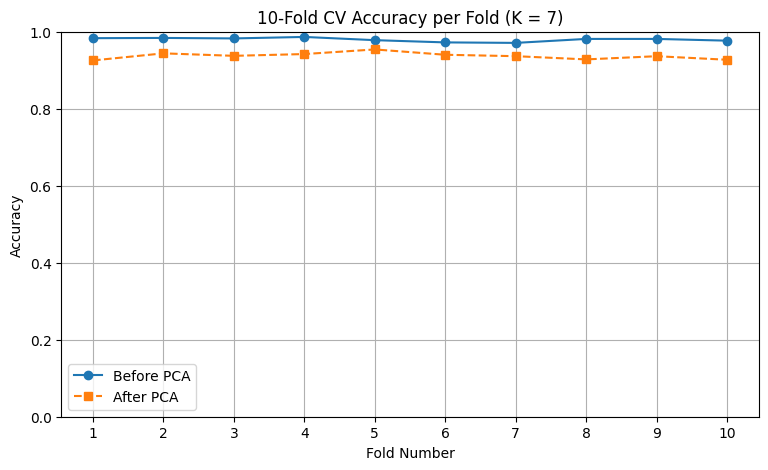

In [14]:
cv_accuracies_before = [m['Accuracy'] for m in fold_metrics_before]
cv_accuracies_after  = [m['Accuracy'] for m in fold_metrics_after]
folds = list(range(1, len(cv_accuracies_before)+1))

plt.figure(figsize=(9, 5))
plt.plot(folds, cv_accuracies_before, marker='o', linestyle='-', label='Before PCA')
plt.plot(folds, cv_accuracies_after, marker='s', linestyle='--', label='After PCA')
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title(f"10-Fold CV Accuracy per Fold (K = {k})")
plt.ylim(0, 1)
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.show()


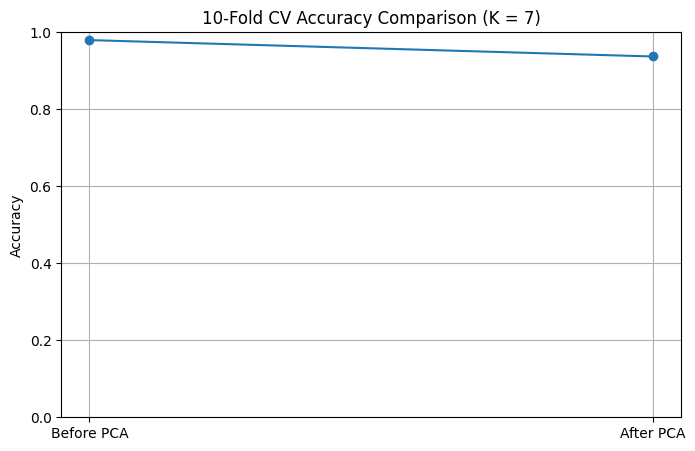

In [16]:
cv_accuracy_before_pca = avg_cv_metrics_before['Accuracy']
cv_accuracy_after_pca = avg_cv_metrics_after['Accuracy']

plt.figure(figsize=(8, 5))

plt.plot(
    ['Before PCA', 'After PCA'],
    [cv_accuracy_before_pca, cv_accuracy_after_pca],
    marker='o',
    linestyle='-'
)

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title(f"10-Fold CV Accuracy Comparison (K = {k})")
plt.grid(True)

plt.show()
